In [54]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, col

import matplotlib.pyplot as plt

In [2]:
# Build the SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("DDAM Project") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext

## Import

In [3]:
df_boxscore = spark.read.csv("data/boxscore_clean.csv", header=True, inferSchema=True)

In [4]:
print(df_boxscore.count())

539171


In [5]:
# Renaming
df_boxscore = df_boxscore.withColumnRenamed("pos_clean", "Position")

In [6]:
df_boxscore.printSchema()

root
 |-- playerName: string (nullable = true)
 |-- game_id: integer (nullable = true)
 |-- teamName: string (nullable = true)
 |-- FG: integer (nullable = true)
 |-- FGA: integer (nullable = true)
 |-- 3P: integer (nullable = true)
 |-- 3PA: integer (nullable = true)
 |-- FT: integer (nullable = true)
 |-- FTA: integer (nullable = true)
 |-- ORB: integer (nullable = true)
 |-- DRB: integer (nullable = true)
 |-- TRB: integer (nullable = true)
 |-- AST: integer (nullable = true)
 |-- STL: integer (nullable = true)
 |-- BLK: integer (nullable = true)
 |-- TOV: integer (nullable = true)
 |-- PF: integer (nullable = true)
 |-- PTS: integer (nullable = true)
 |-- +/-: integer (nullable = true)
 |-- isStarter: integer (nullable = true)
 |-- seasonStartYear: integer (nullable = true)
 |-- isRegular: integer (nullable = true)
 |-- Ht: string (nullable = true)
 |-- Wt: double (nullable = true)
 |-- feet: double (nullable = true)
 |-- inches: string (nullable = true)
 |-- MP_seconds: integer (n

## Standrardizzazione

In [ ]:
"""from pyspark.ml.feature import VectorAssembler, MinMaxScaler

# Selezionare tutte le colonne
selected_columns = df_clustering_clean.columns

# Creare un VectorAssembler
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features")

# Applicare l'assemblatore
output_dataset = assembler.transform(df_clustering_clean)

# Creare uno scaler per normalizzare le features
scaler = MinMaxScaler(inputCol="features", outputCol="features_scaled")

# Applicare lo scaler
output_dataset = scaler.fit(output_dataset).transform(output_dataset)
"""

## Position one-hot-enconding

In [7]:
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Position", outputCol="PosNum", handleInvalid="skip")

df_boxscore = indexer.fit(df_boxscore).transform(df_boxscore)

In [8]:
from pyspark.ml.feature import OneHotEncoder
onehotencoder_embarked_vector = OneHotEncoder(inputCol="PosNum", outputCol="PosVec")
df_boxscore = onehotencoder_embarked_vector.fit(df_boxscore).transform(df_boxscore)
df_boxscore.show()

+------------------+-------+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+----+-----+------------------+------+----------+--------+-------------------+-------------------+-------------------+------+-------------+
|        playerName|game_id|            teamName| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|  Ht|   Wt|              feet|inches|MP_seconds|Position|                TSP|                EFG|           TO_ratio|PosNum|       PosVec|
+------------------+-------+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+----+-----+------------------+------+----------+--------+-------------------+-------------------+-------------------+------+-------------+
|Corliss Williamson|      1|    Sacramento Kings|  7| 11|  0|  0|  0|  0|  1|  3|  4|  4|  1|  1|  4|  5| 14| -2|        1|           19

In [27]:
column2drop = ('playerName', 'game_id', 'teamName', 'seasonStartYear', 'Ht', 'Pos', 'Position', 'Wt', 'feet', 'inches')
df_boxscore = df_boxscore.drop(*column2drop)

In [28]:
# removing correlated features
too_correlated = ('FG', 'FT', 'TRB', 'TSP')
df_boxscore = df_boxscore.drop(*too_correlated)

In [29]:
df_boxscore.printSchema()

root
 |-- FGA: integer (nullable = true)
 |-- 3P: integer (nullable = true)
 |-- 3PA: integer (nullable = true)
 |-- FTA: integer (nullable = true)
 |-- ORB: integer (nullable = true)
 |-- DRB: integer (nullable = true)
 |-- AST: integer (nullable = true)
 |-- STL: integer (nullable = true)
 |-- BLK: integer (nullable = true)
 |-- TOV: integer (nullable = true)
 |-- PF: integer (nullable = true)
 |-- PTS: integer (nullable = true)
 |-- +/-: integer (nullable = true)
 |-- isStarter: integer (nullable = true)
 |-- isRegular: integer (nullable = true)
 |-- MP_seconds: integer (nullable = true)
 |-- EFG: double (nullable = true)
 |-- TO_ratio: double (nullable = true)
 |-- PosNum: double (nullable = false)
 |-- PosVec: vector (nullable = true)



## Data understanding

In [75]:
# Are data balanced?
categorical_columns = ['PosNum']

for column in categorical_columns:
    distinct_values = df_boxscore.groupBy(column).count().collect()
    print(f"Distinct values and frequencies in {column}:")
    for row in distinct_values:
        value = row[column]
        frequency = row["count"]
        print(f"{value}: {frequency}")
    print()

Distinct values and frequencies in PosNum:
0.0: 232742
1.0: 224245
2.0: 82184



## Data preparation

In [30]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [32]:
num_col = [item[0] for item in df_boxscore.dtypes if not item[1].startswith('string')]
num_col.remove("PosNum")
num_col.remove("PosVec")
print(num_col)

['FGA', '3P', '3PA', 'FTA', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', '+/-', 'isStarter', 'isRegular', 'MP_seconds', 'EFG', 'TO_ratio']


In [33]:
assembler = VectorAssembler(inputCols=num_col, outputCol="features")

output_dataset = assembler.transform(df_boxscore)

classificationData = output_dataset.select("features", "PosNum")

classificationData.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------+------+
|features                                                                                                      |PosNum|
+--------------------------------------------------------------------------------------------------------------+------+
|[11.0,0.0,0.0,0.0,1.0,3.0,4.0,1.0,1.0,4.0,5.0,14.0,-2.0,1.0,1.0,2240.0,0.6363636363636364,0.21052631578947367]|1.0   |
|[4.0,0.0,0.0,4.0,2.0,5.0,3.0,1.0,0.0,4.0,3.0,1.0,-12.0,1.0,1.0,1894.0,0.0,0.31347962382445144]                |2.0   |
|[13.0,1.0,2.0,2.0,0.0,2.0,5.0,1.0,1.0,2.0,2.0,17.0,-7.0,1.0,1.0,1767.0,0.5769230769230769,0.09578544061302681]|0.0   |
|[11.0,0.0,0.0,2.0,1.0,5.0,0.0,0.0,2.0,1.0,2.0,8.0,-7.0,1.0,1.0,1513.0,0.2727272727272727,0.07763975155279502] |1.0   |
|[11.0,0.0,2.0,8.0,0.0,1.0,0.0,4.0,0.0,4.0,1.0,14.0,-3.0,0.0,1.0,1529.0,0.36363636363636365,0.2159827213822894]|0.0   |
|[3.0,0.0,0.0,4.0,2.0,8.0,1.0,2.0,0.0,4.

In [34]:
(trainingData, testData) = classificationData.randomSplit([0.7, 0.3],seed=1)

In [36]:
# Validation split
(trainingData, valData) = trainingData.randomSplit([0.8, 0.2],seed=1)

In [73]:
trainingData.show(100, truncate=False)

+-----------------------------------------------------------------------------------------------+------+
|features                                                                                       |PosNum|
+-----------------------------------------------------------------------------------------------+------+
|(18,[],[])                                                                                     |0.0   |
|(18,[],[])                                                                                     |1.0   |
|(18,[],[])                                                                                     |2.0   |
|(18,[0,1,2,3,4,5,11,12,15,16],[3.0,1.0,1.0,2.0,1.0,1.0,7.0,7.0,99.0,1.1666666666666667])       |0.0   |
|(18,[0,1,2,3,4,5,11,12,15,16],[5.0,2.0,3.0,9.0,1.0,1.0,15.0,2.0,960.0,0.6])                    |0.0   |
|(18,[0,1,2,3,4,5,11,12,15,16],[8.0,4.0,6.0,6.0,1.0,5.0,17.0,17.0,1217.0,0.75])                 |0.0   |
|(18,[0,1,2,3,4,5,11,14,15,16],[1.0,1.0,1.0,3.0,1.0,1.0

## Decision Tree

In [80]:
def plot_importance(importance):
    keys = importance.keys()
    values = importance.values()

    # Plot the dictionary
    plt.figure(figsize=(17,5))
    plt.bar(keys, values)
    plt.xlabel("Keys")
    plt.ylabel("Values")
    plt.title("Dictionary Plot")
    plt.show()

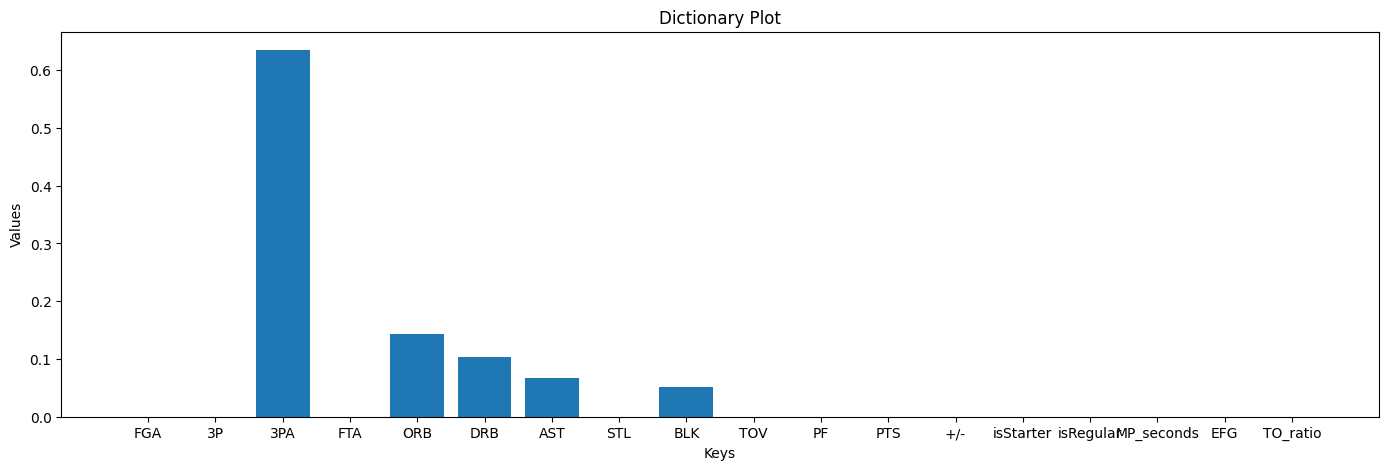

With parameters {'maxDepth': 3, 'maxBins': 16, 'impurity': 'entropy'}
Validation accuracy = 0.598228140210342


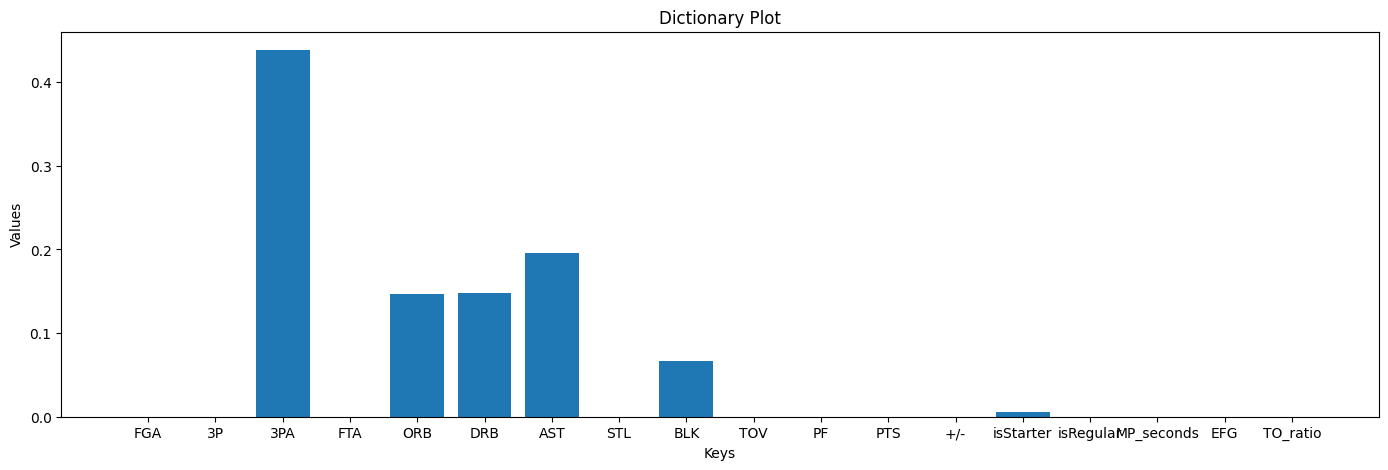

With parameters {'maxDepth': 5, 'maxBins': 16, 'impurity': 'gini'}
Validation accuracy = 0.6263179533427938


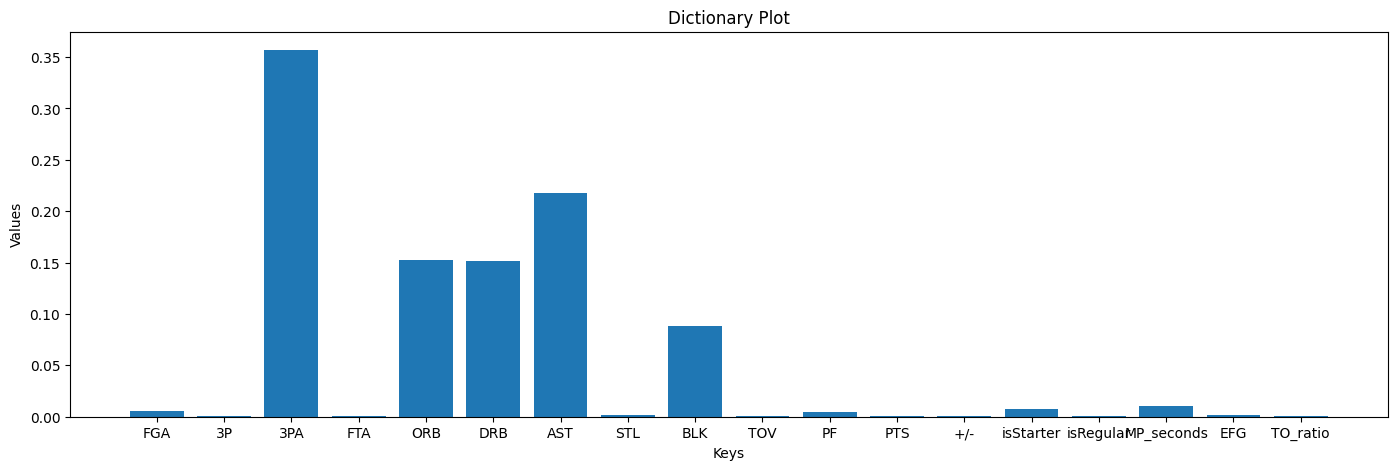

With parameters {'maxDepth': 9, 'maxBins': 32, 'impurity': 'gini'}
Validation accuracy = 0.6463442129414729


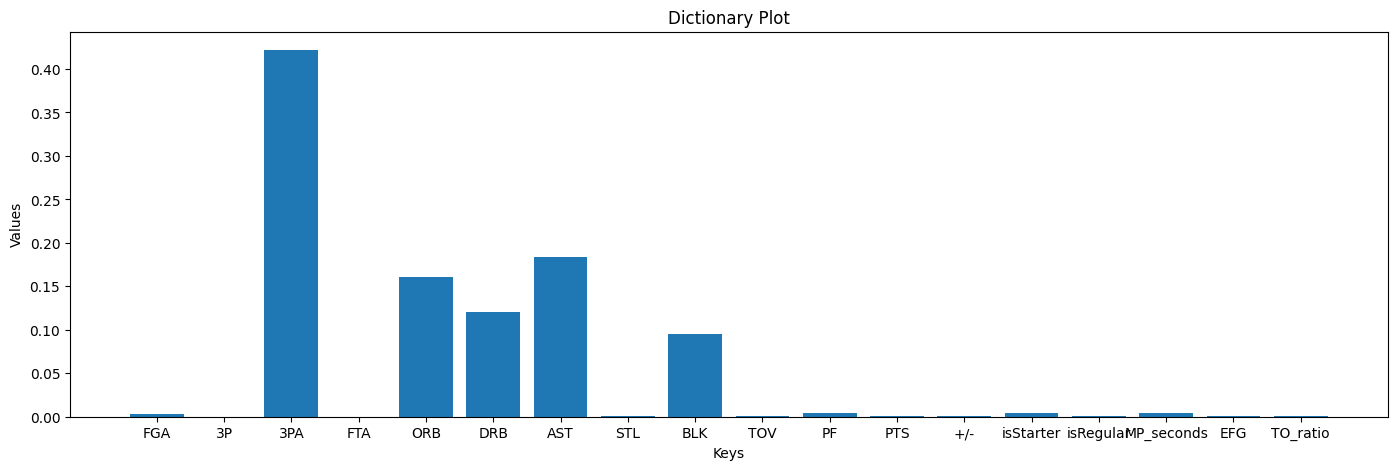

With parameters {'maxDepth': 9, 'maxBins': 64, 'impurity': 'entropy'}
Validation accuracy = 0.6470205965438124


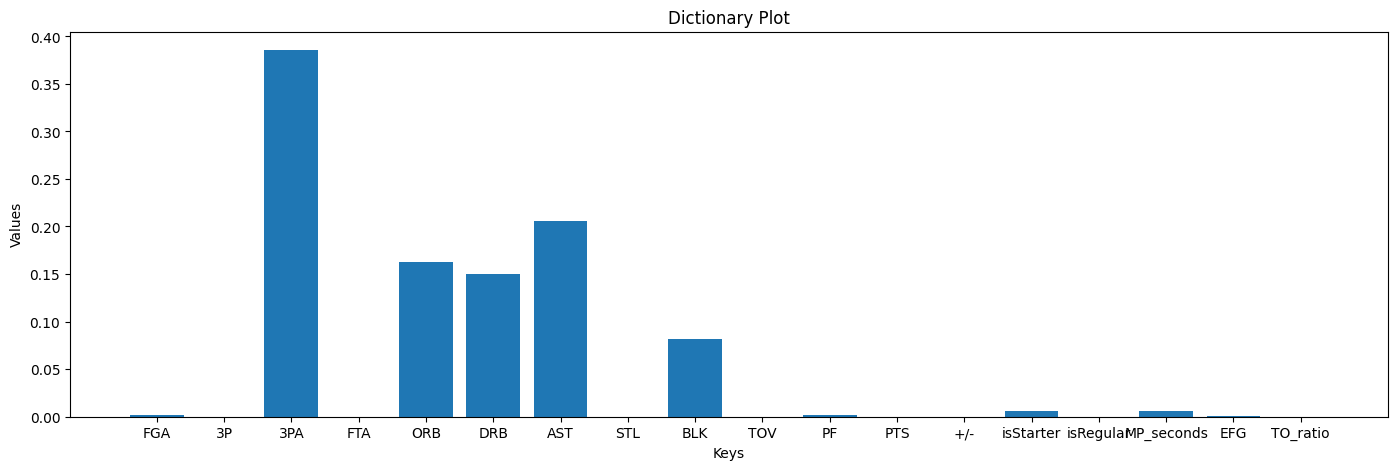

With parameters {'maxDepth': 7, 'maxBins': 64, 'impurity': 'gini'}
Validation accuracy = 0.6396997387302555


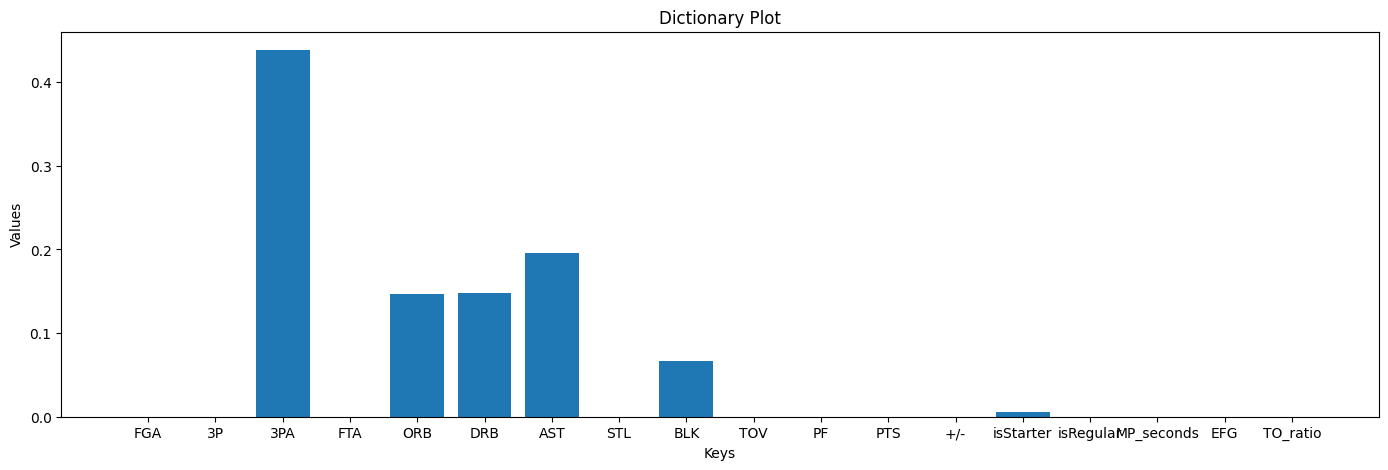

With parameters {'maxDepth': 5, 'maxBins': 64, 'impurity': 'gini'}
Validation accuracy = 0.6263179533427938


In [81]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
import random
import itertools

# random search
hyperparameters = {
    'maxDepth': [3, 5, 7, 9],
    'maxBins' : [16, 32, 64],
    'impurity' : ['gini', 'entropy']
}

number_of_combinations = 6
random_combinations = random.sample(list(itertools.product(*hyperparameters.values())), number_of_combinations)

for combo in random_combinations:
    param_dict = dict(zip(hyperparameters.keys(), combo))

    dt = DecisionTreeClassifier(labelCol="PosNum", featuresCol="features", impurity=param_dict['impurity'], maxDepth=param_dict['maxDepth'], maxBins=param_dict['maxBins'])

    dt = dt.fit(trainingData)

    importance = {}
    featureImportances = list(dt.featureImportances)

    for i,e in enumerate(featureImportances):
        importance[num_col[i]] = e
    
    plot_importance(importance)

    # Make predictions
    predictions = dt.transform(valData)

    # Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(labelCol="PosNum"
                                                , predictionCol="prediction"
                                                , metricName="accuracy")

    print('With parameters', param_dict)
    accuracy = evaluator.evaluate(predictions)
    print('Validation accuracy =', accuracy)

In [82]:
dt = DecisionTreeClassifier(labelCol="PosNum", featuresCol="features", impurity='entropy', maxDepth=9, maxBins=64)

dt = dt.fit(trainingData)

In [83]:
dt.featureImportances

SparseVector(18, {0: 0.0031, 1: 0.0001, 2: 0.4218, 3: 0.0001, 4: 0.1605, 5: 0.1208, 6: 0.1834, 7: 0.0006, 8: 0.0955, 9: 0.0002, 10: 0.0041, 11: 0.0002, 12: 0.0003, 13: 0.0037, 14: 0.0001, 15: 0.0047, 16: 0.0006, 17: 0.0002})

In [84]:
importance = {}
featureImportances = list(dt.featureImportances)

for i,e in enumerate(featureImportances):
    importance[num_col[i]] = e

importance

{'FGA': 0.0031247418562662626,
 '3P': 9.01996984643219e-05,
 '3PA': 0.42179289124661684,
 'FTA': 7.834537572766489e-05,
 'ORB': 0.1604927213946295,
 'DRB': 0.12076705545689294,
 'AST': 0.18341924516694447,
 'STL': 0.0005737519089929173,
 'BLK': 0.0954800907758611,
 'TOV': 0.00024509913427441454,
 'PF': 0.004096806003917114,
 'PTS': 0.00019599991288277486,
 '+/-': 0.0003107258422795246,
 'isStarter': 0.003690070008954725,
 'isRegular': 0.00014698741591814458,
 'MP_seconds': 0.004693232317249046,
 'EFG': 0.0006081939496410529,
 'TO_ratio': 0.00019384253448726237}

In [85]:
# Make predictions
predictions = dt.transform(valData)

predictions.show(10)

+--------------------+------+--------------------+--------------------+----------+
|            features|PosNum|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|(18,[0,1,2,3,4,5,...|   0.0|  [937.0,678.0,23.0]|[0.57203907203907...|       0.0|
|(18,[0,1,2,3,4,6,...|   1.0|  [877.0,656.0,29.0]|[0.56145966709347...|       0.0|
|(18,[0,1,2,3,4,6,...|   0.0|[3058.0,1317.0,61.0]|[0.68935978358881...|       0.0|
|(18,[0,1,2,3,4,6,...|   1.0|  [877.0,656.0,29.0]|[0.56145966709347...|       0.0|
|(18,[0,1,2,3,4,8,...|   0.0|  [369.0,747.0,71.0]|[0.31086773378264...|       1.0|
|(18,[0,1,2,3,4,11...|   1.0|  [877.0,656.0,29.0]|[0.56145966709347...|       0.0|
|(18,[0,1,2,3,4,11...|   0.0|  [488.0,527.0,50.0]|[0.45821596244131...|       1.0|
|(18,[0,1,2,3,4,11...|   0.0|  [488.0,527.0,50.0]|[0.45821596244131...|       1.0|
|(18,[0,1,2,3,4,11...|   0.0|  [488.0,527.0,50.0]|[0.45821596244131...|       1.0|
|(18

In [87]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="PosNum"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print('Validation accuracy =', accuracy)
print("Validation Error = %g" % (1.0 - accuracy))

predictions_test = dt.transform(testData)
accuracy_test = evaluator.evaluate(predictions_test)
print('Test accuracy =', accuracy_test)
print("Test Error = %g" % (1.0 - accuracy_test))

Validation accuracy = 0.6470205965438124
Validation Error = 0.352979
Test accuracy = 0.6444879803841841
Test Error = 0.355512


Using 'Ht', the decision tree obtains nearly 89% of accuracy. Without it, we reach 65% accuracy on the validation set.

## Gradient-Boosted Tree

In [20]:
# Save the model for future use
#model.save("path_to_save_model")

# Load the saved model
#loaded_model = GBTClassifier.load("path_to_saved_model")

## Multilayer Perceptron Classifier

In [42]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

layers = [18, 40, 20, 3]  # Define the layers of the neural network
mlp = MultilayerPerceptronClassifier(labelCol="PosNum", featuresCol="features", layers=layers, seed=1234)

model = mlp.fit(trainingData)

predictions = model.transform(valData)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="PosNum", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Validation accuracy:", accuracy)

Validation accuracy: 0.6251508600681689


In [43]:
predictions.show(20)

+--------------------+------+--------------------+--------------------+----------+
|            features|PosNum|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|(18,[0,1,2,3,4,5,...|   0.0|[0.97611268591636...|[0.69901988737078...|       0.0|
|(18,[0,1,2,3,4,6,...|   1.0|[1.00910893612434...|[0.70667048061294...|       0.0|
|(18,[0,1,2,3,4,6,...|   0.0|[1.06774296004775...|[0.71998309184975...|       0.0|
|(18,[0,1,2,3,4,6,...|   1.0|[0.97420395779076...|[0.69857383463659...|       0.0|
|(18,[0,1,2,3,4,8,...|   0.0|[1.06878887847958...|[0.72021721654325...|       0.0|
|(18,[0,1,2,3,4,11...|   1.0|[0.07962012577474...|[0.46081346408923...|       0.0|
|(18,[0,1,2,3,4,11...|   0.0|[0.29180779713273...|[0.51931165714625...|       0.0|
|(18,[0,1,2,3,4,11...|   0.0|[0.91819523071249...|[0.68530782533391...|       0.0|
|(18,[0,1,2,3,4,11...|   0.0|[0.92927002187727...|[0.68768020079925...|       0.0|
|(18

In [44]:
model

MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_02cae326c37a, numLayers=4, numClasses=3, numFeatures=18